# 1. Prerequisites and Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np
import requests
import torch
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from textblob import TextBlob
from wordcloud import WordCloud

from PIL import Image, UnidentifiedImageError
from io import BytesIO

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

c:\Users\ADMIN\anaconda3\envs\cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Configuration
BASE_URL = "McAuley-Lab/Amazon-Reviews-2023"
CATEGORY = "All_Beauty"

RATINGS_URL = f"5core_rating_only_{CATEGORY}"
REVIEWS_URL = f"raw_review_{CATEGORY}"
METADATA_URL = f"raw_meta_{CATEGORY}"

# 2. Basic Dataset Checkup

In [3]:
def load_data(path):
    try: 
        data = load_dataset(BASE_URL, path)
        df = data["full"].to_pandas()
        return df
    except:
        print("Dataset loaded unsuccessfully.")

In [4]:
ratings_df = load_data(RATINGS_URL)
ratings_df.head(5)

,user_id,parent_asin,rating,timestamp
0,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07J3GH1W1,5.0,1547589356557
1,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07W397QG4,5.0,1593352422858
2,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07KG1TWP5,5.0,1596473351088
3,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08JTNQFZY,5.0,1617904219785
4,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07SLFWZKN,3.0,1619737501209


In [5]:
reviews_df = load_data(REVIEWS_URL)
reviews_df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,"This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!",[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was described but I was hoping it would be light)",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [6]:
metadata_df = load_data(METADATA_URL)
metadata_df.head(5)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)",4.8,10,[],[],None,"{'hi_res': [None, 'https://m.media-amazon.com/images/I/71i77AuI9xL._SL1500_.jpg'], 'large': ['https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg', 'https://m.media-amazon.com/images/I/41w2yznfuZL.jpg'], 'thumb': ['https://m.media-amazon.com/images/I/41qfjSfqNyL._SS40_.jpg', 'https://m.media-amazon.com/images/I/41w2yznfuZL._SS40_.jpg'], 'variant': ['MAIN', 'PT01']}","{'title': [], 'url': [], 'user_id': []}",Howard Products,[],"{""Package Dimensions"": ""7.1 x 5.5 x 3 inches; 2.38 Pounds"", ""UPC"": ""617390882781""}",B01CUPMQZE,None,None,None
1,All Beauty,"Yes to Tomatoes Detoxifying Charcoal Cleanser (Pack of 2) with Charcoal Powder, Tomato Fruit Extract, and Gingko Biloba Leaf Extract, 5 fl. oz.",4.5,3,[],[],None,"{'hi_res': ['https://m.media-amazon.com/images/I/71g1lP0pMbL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/81OqvR94isL._SL1500_.jpg'], 'large': ['https://m.media-amazon.com/images/I/41b+11d5igL.jpg', 'https://m.media-amazon.com/images/I/41j2ocUzCtL.jpg'], 'thumb': ['https://m.media-amazon.com/images/I/41b+11d5igL._SS40_.jpg', 'https://m.media-amazon.com/images/I/41j2ocUzCtL._SS40_.jpg'], 'variant': ['MAIN', 'PT01']}","{'title': [], 'url': [], 'user_id': []}",Yes To,[],"{""Item Form"": ""Powder"", ""Skin Type"": ""Acne Prone"", ""Brand"": ""Yes To"", ""Age Range (Description)"": ""Adult"", ""Unit Count"": ""10 Fl Oz"", ""Is Discontinued By Manufacturer"": ""No"", ""Item model number"": ""SG_B076WQZGPM_US"", ""UPC"": ""653801351125"", ""Manufacturer"": ""Yes to Tomatoes""}",B076WQZGPM,None,None,None
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],None,"{'hi_res': [None, None], 'large': ['https://m.media-amazon.com/images/I/31bz+uqzWCL.jpg', 'https://m.media-amazon.com/images/I/31bz+uqzWCL.jpg'], 'thumb': ['https://m.media-amazon.com/images/I/31bz+uqzWCL._SS40_.jpg', 'https://m.media-amazon.com/images/I/31bz+uqzWCL._SS40_.jpg'], 'variant': ['MAIN', 'PT01']}","{'title': [], 'url': [], 'user_id': []}",Levine Health Products,[],"{""Manufacturer"": ""Levine Health Products""}",B000B658RI,None,None,None
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4D Imitation Eyebrow Tattoos, 4D Hair-like Authentic Eyebrows Waterproof Long Lasting for Woman & Man Makeup Tool",3.1,102,[],[],None,"{'hi_res': ['https://m.media-amazon.com/images/I/71GJhXQGvyL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/61NS1lONhzL._SL1001_.jpg', 'https://m.media-amazon.com/images/I/61lcwXtw3ZL._SL1001_.jpg', 'https://m.media-amazon.com/images/I/61G-iZeX-LL._SL1001_.jpg', 'https://m.media-amazon.com/images/I/618BBBsAQrL._SL1001_.jpg', 'https://m.media-amazon.com/images/I/61iomcZjbAL._SL1001_.jpg', 'https://m.media-amazon.com/images/I/61m-71vCbCL._SL1001_.jpg'], 'large': ['https://m.media-amazon.com/images/I/515iwxdKS1L.jpg', 'https://m.media-amazon.com/images/I/51ALSVnGDML.jpg', 'https://m.media-amazon.com/images/I/51GvPall-ML.jpg', 'https://m.media-amazon.com/images/I/51JFEUql-KL.jpg', 'https://m.media-amazon.com/images/I/414rIT4vNAL.jpg', 'https://m.media-amazon.com/images/I/41JVLUdtYaL.jpg', 'https://m.media-amazon.com/images/I/51Vxn6nVrVL.jpg'], 'thumb': ['https://m.media-amazon.com/images/I/515iwxdKS1L._SS40_.jpg', 'https://m.media-amazon.com/images/I/51ALSVnGDML._SS40_.jpg', 'https://m.media-amazon.com/images/I/51GvPall-ML._SS40_.jpg', 'https://m.media-amazon.com/images/I/51JFEUql-KL._SS40_.jpg', 'https://m.media-amazon.com/images/I/414rIT4vNAL._SS40_.jpg', 'https://m.media-amazon.com/images/I/41JVLUdtYaL._SS40_.jpg', 'https://m.media-amazon.com/images/I/51Vxn6nVrVL._SS40_.jpg'], 'variant': ['MAIN', 'PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06']}","{'title': [], 'url': [], 'user_id': []}",Cherioll,[],"{""Brand"": ""Cherioll"", ""Item Form"": ""Powder"", ""Fi

In [7]:
# Shape inspection
print(f"5-core Ratings Shape: {ratings_df.shape}  (Rows = Interactions)")
print(f"Full Reviews Shape: {reviews_df.shape}  (Rows = Total Reviews)")
print(f"Metadata Shape: {metadata_df.shape} (Rows = Unique Products)")

5-core Ratings Shape: (2535, 4)  (Rows = Interactions)
Full Reviews Shape: (701528, 10)  (Rows = Total Reviews)
Metadata Shape: (112590, 16) (Rows = Unique Products)


In [8]:
# Check columns info 
ratings_df.info()
reviews_df.info()
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      2535 non-null   object
 1   parent_asin  2535 non-null   object
 2   rating       2535 non-null   object
 3   timestamp    2535 non-null   object
dtypes: object(4)
memory usage: 79.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             701528 non-null  float64
 1   title              701528 non-null  object 
 2   text               701528 non-null  object 
 3   images             701528 non-null  object 
 4   asin               701528 non-null  object 
 5   parent_asin        701528 non-null  object 
 6   user_id            701528 non-null  object 
 7   timestamp          701528 non-null  int64  
 8   h

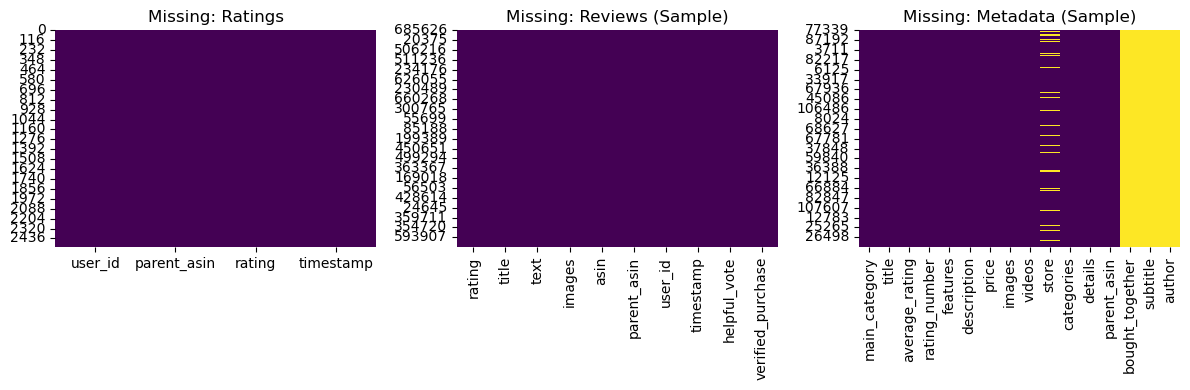

In [9]:
# Visualize missing data
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.heatmap(ratings_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing: Ratings')

plt.subplot(1, 3, 2)
# Sample reviews if dataset is huge to prevent crash
sns.heatmap(reviews_df.sample(min(10000, len(reviews_df))).isnull(), cbar=False, cmap='viridis')
plt.title('Missing: Reviews (Sample)')

plt.subplot(1, 3, 3)
sns.heatmap(metadata_df.sample(min(10000, len(metadata_df))).isnull(), cbar=False, cmap='viridis')
plt.title('Missing: Metadata (Sample)')

plt.tight_layout()
plt.show()

In [10]:
# Check empty fields in images column 
def check_empty_images(val):
    if isinstance(val, list):
        return len(val) == 0
    return pd.isna(val)

empty_imgs_pct = metadata_df['images'].apply(check_empty_images).mean() * 100
print(f"\nPercentage of products with no images: {empty_imgs_pct:.2f}%")


Percentage of products with no images: 0.00%


In [11]:
# Check the overlapped data between dfs
# The ratings_df and metadat_df are joined on the key "parent_asin"

# First, we'll check the number of 5-core items present in the metadata
unique_items_5core = ratings_df['parent_asin'].unique()
unique_items_meta = set(metadata_df['parent_asin'].unique())
overlap_items = sum([1 for x in unique_items_5core if x in unique_items_meta])
item_coverage = (overlap_items / len(unique_items_5core)) * 100

print(f"Item Coverage: {item_coverage:.2f}% of 5-core items found in Metadata.")

Item Coverage: 100.00% of 5-core items found in Metadata.


In [12]:
# Second, we'll check the number of 5-core users present in the reviews data
unique_users_5core = ratings_df["parent_asin"].unique()
unique_users_reviews = set(reviews_df['parent_asin'].unique())
overlap_users = sum([1 for x in unique_users_5core if x in unique_users_reviews])
user_coverage = (overlap_users / len(unique_users_5core)) * 100

print(f"User Coverage: {user_coverage:.2f}% of 5-core users found in Reviews.")

User Coverage: 100.00% of 5-core users found in Reviews.


# 3. Ratings EDA

In [13]:
# Basic Counts
n_users = ratings_df['user_id'].nunique()
n_items = ratings_df['parent_asin'].nunique()
n_ratings = len(ratings_df)

print(f"Total Users: {n_users}")
print(f"Total Items: {n_items}")
print(f"Total Interactions: {n_ratings}")

Total Users: 253
Total Items: 356
Total Interactions: 2535


### 3.1 Interaction Distribution

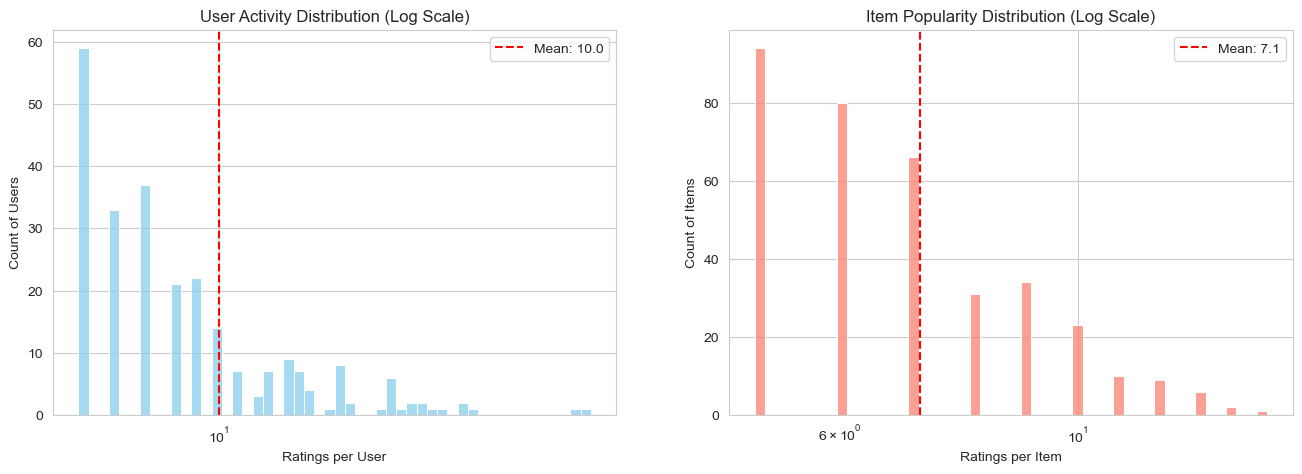

In [14]:
# Plotting Activity Distribution (Ratings per User & Ratings per Item)
# We use log-scale because the dataset is big and needs compressing for better visibility
user_activity = ratings_df.groupby('user_id')['parent_asin'].count()
item_popularity = ratings_df.groupby('parent_asin')['user_id'].count()

sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# User Activity
sns.histplot(user_activity, bins=50, log_scale=True, ax=ax[0], color='skyblue')
ax[0].set_title('User Activity Distribution (Log Scale)')
ax[0].set_xlabel('Ratings per User')
ax[0].set_ylabel('Count of Users')
ax[0].axvline(user_activity.mean(), color='r', linestyle='--', label=f'Mean: {user_activity.mean():.1f}')
ax[0].legend()

# Item Popularity
sns.histplot(item_popularity, bins=50, log_scale=True, ax=ax[1], color='salmon')
ax[1].set_title('Item Popularity Distribution (Log Scale)')
ax[1].set_xlabel('Ratings per Item')
ax[1].set_ylabel('Count of Items')
ax[1].axvline(item_popularity.mean(), color='r', linestyle='--', label=f'Mean: {item_popularity.mean():.1f}')
ax[1].legend()

plt.show()

**Comment**:
- The distribution of user activity is highly skewed, with the majority of users contributing only a small number of reviews. Most users rate between 1 and 5 items, while a much smaller group of users contribute significantly more. The long right tail indicates that a few users provide dozens or even hundreds of ratings.
- Item popularity shows a similarly long-tailed distribution. Most items receive only a handful of ratings, while a small number of popular or trending items attract a disproportionately large number of reviews.

### 3.2 Temporal Patterns

This checks if the data has time-based biases (seasonality) or trends (platform growth).

In [15]:
# Convert timestamp to datetime
ratings_df['date'] = pd.to_datetime(ratings_df['timestamp'], unit='ms')
ratings_df['year_month'] = ratings_df['date'].dt.to_period('M')

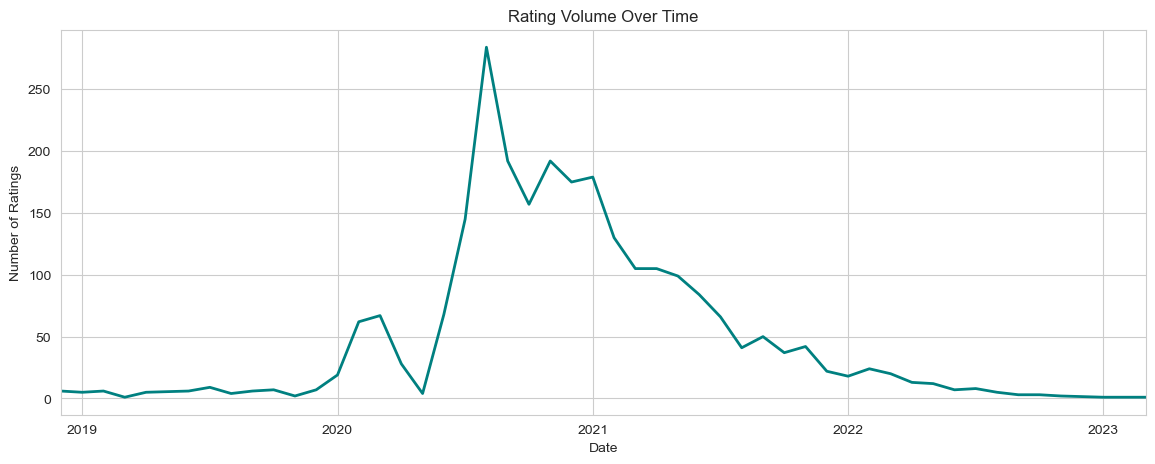

In [16]:
# Visualize Rating Volumne Over Time
monthly_counts = ratings_df.groupby('year_month').size()

plt.figure(figsize=(14, 5))
monthly_counts.plot(kind='line', color='teal', linewidth=2)
plt.title('Rating Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

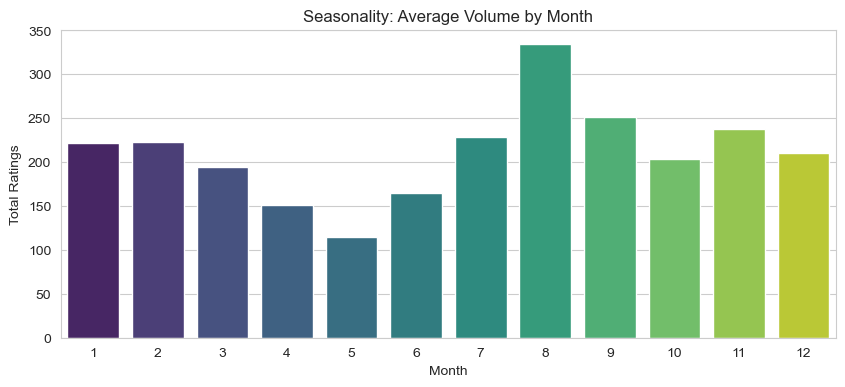

In [17]:
# Analyze Seasonality
ratings_df['month'] = ratings_df['date'].dt.month
seasonal_counts = ratings_df.groupby('month').size()

plt.figure(figsize=(10, 4))
sns.barplot(x=seasonal_counts.index, y=seasonal_counts.values, palette='viridis')
plt.title('Seasonality: Average Volume by Month')
plt.xlabel('Month')
plt.ylabel('Total Ratings')
plt.show()

### 3.3 Rating Distribution

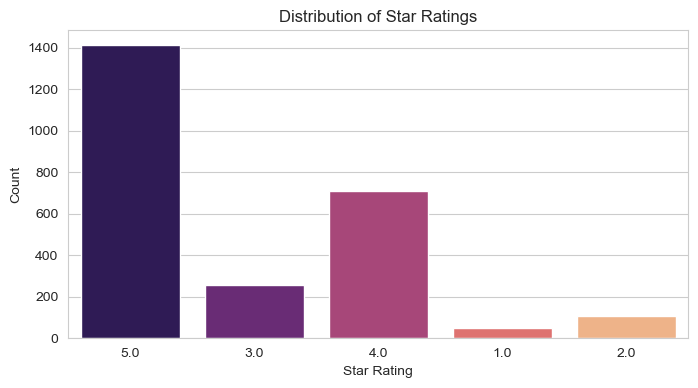

In [18]:
# Plot Histogram
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=ratings_df, palette='magma')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

In [19]:
ratings_df['rating'] = pd.to_numeric(ratings_df['rating'], errors='coerce')

mean_rating = ratings_df['rating'].mean()
print(f"Global Average Rating: {mean_rating:.2f}")

Global Average Rating: 4.31


# 4. Textual Reviews EDA

### 4.1 Text Length Statistics

In [20]:
# Ensure text columns are strings
reviews_df['text'] = reviews_df['text'].fillna('').astype(str)
reviews_df['title'] = reviews_df['title'].fillna('').astype(str)

In [21]:
# Compute lengths
reviews_df['char_count'] = reviews_df['text'].apply(len)
# Approximate token count by splitting on whitespace
reviews_df['word_count'] = reviews_df['text'].apply(lambda x: len(x.split()))

print(reviews_df[['char_count', 'word_count']].describe())

          char_count     word_count
count  701528.000000  701528.000000
mean      173.031641      32.750720
std       246.924645      45.973273
min         0.000000       0.000000
25%        44.000000       8.000000
50%       102.000000      19.000000
75%       209.000000      40.000000
max     14989.000000    2585.000000


In [22]:
metadata_df['title_len'] = metadata_df['title'].fillna("").apply(lambda x: len(str(x).split()))
metadata_df['desc_len'] = metadata_df['description'].fillna("").apply(lambda x: len(str(x).split()))

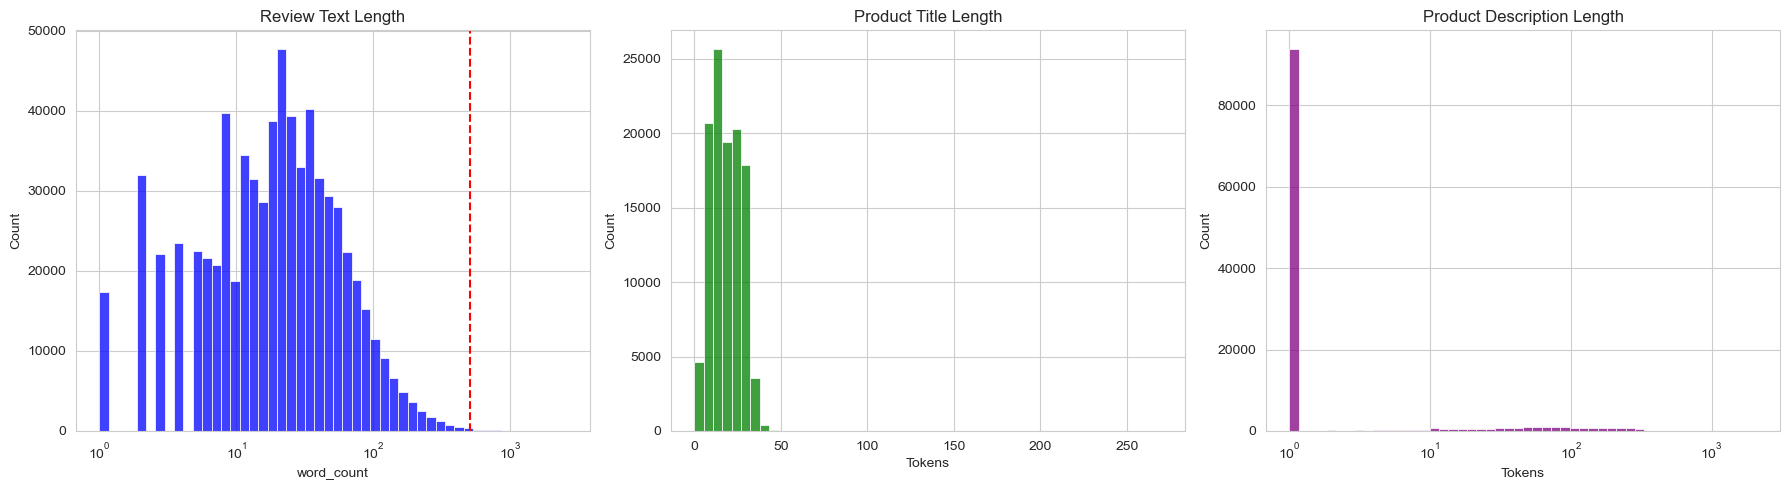

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. Review Text 
if 'word_count' in reviews_df.columns:
    sns.histplot(reviews_df['word_count'], ax=ax[0], bins=50, color='blue', log_scale=True)
    ax[0].set_title('Review Text Length')
    ax[0].axvline(512, color='r', linestyle='--', label='BERT Limit')

# 2. Product Title
sns.histplot(metadata_df['title_len'], ax=ax[1], bins=50, color='green')
ax[1].set_title('Product Title Length')
ax[1].set_xlabel('Tokens')

# 3. Product Description
sns.histplot(metadata_df['desc_len'], ax=ax[2], bins=50, color='purple', log_scale=True)
ax[2].set_title('Product Description Length')
ax[2].set_xlabel('Tokens')

plt.tight_layout()
plt.show()

In [24]:
p95_title = metadata_df['title_len'].quantile(0.95)
p95_desc = metadata_df['desc_len'].quantile(0.95)
print(f"95th Percentile Title Length: {p95_title:.0f} tokens")
print(f"95th Percentile Desc Length:  {p95_desc:.0f} tokens")
print(f"Recommended max_seq_length for Title: {int(p95_title + 10)}")

95th Percentile Title Length: 32 tokens
95th Percentile Desc Length:  105 tokens
Recommended max_seq_length for Title: 42


In [25]:
long_reviews = reviews_df[reviews_df['word_count'] > 500].shape[0]
print(f"Reviews exceeding standard BERT limit (~500 words): {long_reviews} ({long_reviews/len(reviews_df)*100:.2f}%)")

Reviews exceeding standard BERT limit (~500 words): 534 (0.08%)


### 4.2 Text Quality and Noise Detection

In [26]:
# Users sometimes double-click submit, or bots post identical spam.
duplicates = reviews_df.duplicated(subset=['text']).sum()
print(f"Duplicate Review Texts: {duplicates} ({duplicates/len(reviews_df)*100:.2f}%)")

Duplicate Review Texts: 57899 (8.25%)


In [27]:
# Identify Low Content Reviews
# Reviews like "Good", "Ok", "Nice" are not useful for embedding models.
short_reviews = reviews_df[reviews_df['word_count'] < 3]
print(f"Very Short Reviews (< 3 words): {len(short_reviews)} ({len(short_reviews)/len(reviews_df)*100:.2f}%)")

# View top short reviews
print("\nMost common short reviews:")
print(short_reviews['text'].value_counts().head(10))

Very Short Reviews (< 3 words): 50058 (7.14%)

Most common short reviews:
text
Love it          1651
Good             1479
Great            1257
Great product    1087
Nice              688
Love it!          662
Perfect           630
                  613
good              561
Good product      540
Name: count, dtype: int64


In [28]:
empty_text = reviews_df[reviews_df['text'].str.strip() == ''].shape[0]
print(f"Empty/Whitespace-only Reviews: {empty_text}")

Empty/Whitespace-only Reviews: 720


### 4.3 Sentiment Analysis

In [29]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

reviews_df['sentiment'] = reviews_df['text'].apply(get_sentiment)

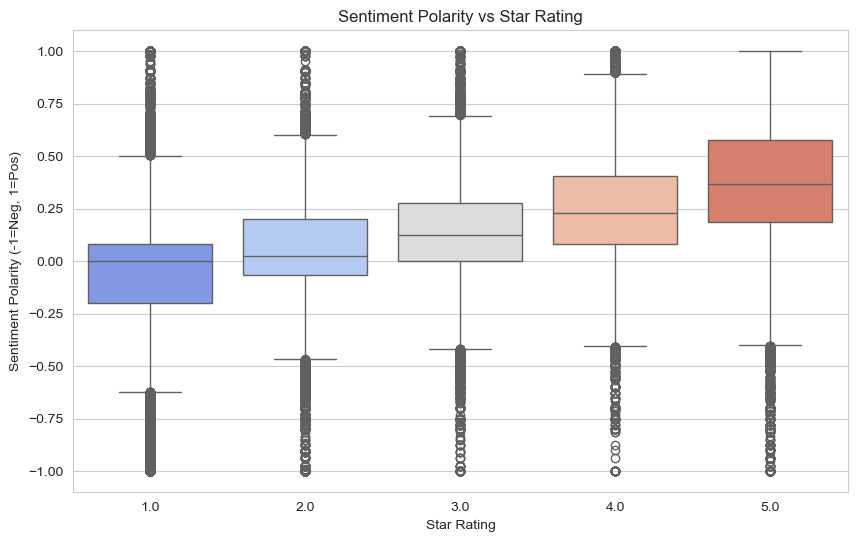

In [30]:
# Plot Sentiment vs Rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='sentiment', data=reviews_df, palette='coolwarm')
plt.title('Sentiment Polarity vs Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Polarity (-1=Neg, 1=Pos)')
plt.show()

In [31]:
# Detect Mismatches (Sarcasm or Error)
# High Rating (5) but Negative Sentiment (< -0.5)
mismatches = reviews_df[(reviews_df['rating'] == 5) & (reviews_df['sentiment'] < -0.5)]
print(f"Potential Mismatches found (5-star but negative text): {len(mismatches)}")

if len(mismatches) > 0:
    print(mismatches[['rating', 'sentiment', 'text']].head(3))

Potential Mismatches found (5-star but negative text): 456
      rating  sentiment                                                 text
3548     5.0  -0.800000                     Used as a base for e-cigarettes.
4924     5.0  -0.714286  Waves make people sea sick from looking at my head.
8750     5.0  -0.700000              My feet sweats badly and it helps them.


In [32]:
# Again, Detect Mismatches, but this time with Low Rating but Positive Sentiment 
mismatches_again = reviews_df[(reviews_df['rating'] == 1) & (reviews_df['sentiment'] > 0.5)]
print(f"Potential Mismatches found (1-star but positive text): {len(mismatches)}")

if len(mismatches_again) > 0:
    print(mismatches_again[['rating', 'sentiment', 'text']].head(3))

Potential Mismatches found (1-star but positive text): 456
      rating  sentiment                                                                                                                              text
1210     1.0      0.625                                             So Cheap! They Melt & Snap Apart as Soon as The Body Heat From Your Scalp Touches It!
1967     1.0      1.000  These sold for 9.00 during closeout on perfectly posh.com this is against p&p to sell something way over the cost of the product
2137     1.0      0.800                                                    They would not work for me<br />I had to give it away<br />Not happy with them


### 4.4 Language Check

In [33]:
# Language Check (Basic check for non-ASCII characters)
def has_non_ascii(text):
    return not all(ord(c) < 128 for c in text)

non_english_chars = reviews_df['text'].apply(has_non_ascii).sum()
print(f"\nReviews with non-ASCII characters (potential non-English/Emojis): {non_english_chars} ({non_english_chars/len(reviews_df)*100:.2f}%)")


Reviews with non-ASCII characters (potential non-English/Emojis): 104044 (14.83%)


# 5. Image EDA

### 5.1 Image Availability

In [34]:
def parse_image_metadata(image_entry):
    """
    Extracts the best available URL and the count of images.
    Returns tuple: (primary_url, image_count)
    """
    if not isinstance(image_entry, dict) or not image_entry:
        return None, 0
    
    # A. Determine Image Count
    # We use the 'large' list as the standard for how many displayable angles exist.
    # We filter out None values just in case.
    valid_images = [img for img in image_entry.get('large', []) if img]
    count = len(valid_images)
    
    # B. Extract Primary URL (Priority: Hi-Res > Large > Thumb)
    primary_url = None
    
    # 1. Try Hi-Res (Skip None values, which are common in this dataset)
    if 'hi_res' in image_entry and isinstance(image_entry['hi_res'], list):
        for url in image_entry['hi_res']:
            if url: # Check if string is not None and not empty
                primary_url = url
                break
    
    # 2. Fallback to Large if Hi-Res failed
    if not primary_url and count > 0:
        primary_url = valid_images[0]
        
    # 3. Last resort: Thumb
    if not primary_url and 'thumb' in image_entry and isinstance(image_entry['thumb'], list):
         for url in image_entry['thumb']:
            if url:
                primary_url = url
                break
                
    return primary_url, count

In [35]:
parsed_data = metadata_df['images'].apply(parse_image_metadata).apply(pd.Series)
parsed_data.columns = ['primary_image_url', 'image_count']

# Assign back to metadata dataframe
metadata_df['primary_image_url'] = parsed_data['primary_image_url']
metadata_df['image_count'] = parsed_data['image_count']

In [36]:
total_products = len(metadata_df)
products_with_img = metadata_df['primary_image_url'].notnull().sum()
avg_images = metadata_df['image_count'].mean()

print(f"Total Products: {total_products}")
print(f"Products with at least 1 valid image: {products_with_img} ({products_with_img/total_products*100:.2f}%)")
print(f"Average images per product: {avg_images:.2f}")

Total Products: 112590
Products with at least 1 valid image: 112590 (100.00%)
Average images per product: 4.88


In [37]:
# Drop products with no images for the next steps (downloading/embeddings)
valid_img_df = metadata_df[metadata_df['primary_image_url'].notnull()].copy()

# Sanity check to see a sample URL
print("\nSample Extracted URL:")
print(valid_img_df['primary_image_url'].iloc[0])


Sample Extracted URL:
https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg


### 5.2 Image Downloading & Quality Check

In [38]:
SAMPLE_SIZE = 200  
sample_imgs = valid_img_df.sample(n=min(SAMPLE_SIZE, len(valid_img_df)), random_state=42)

downloaded_images = [] 
resolutions = []
aspect_ratios = []
failed_downloads = 0

In [39]:
for idx, row in tqdm(sample_imgs.iterrows(), total=len(sample_imgs)):
    url = row['primary_image_url']
    try:
        response = requests.get(url, timeout=3)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            img = img.convert('RGB') # Ensure 3 channels
            
            # Metadata collection
            w, h = img.size
            resolutions.append((w, h))
            aspect_ratios.append(w / h)
            downloaded_images.append({'parent_asin': row['parent_asin'], 'image': img})
        else:
            failed_downloads += 1
    except (requests.RequestException, UnidentifiedImageError):
        failed_downloads += 1

print(f"\nDownload Report:")
print(f"Success: {len(downloaded_images)}")
print(f"Failed/Corrupted/404: {failed_downloads} ({(failed_downloads/SAMPLE_SIZE)*100:.1f}%)")

100%|██████████| 200/200 [00:49<00:00,  4.06it/s]


Download Report:
Success: 199
Failed/Corrupted/404: 1 (0.5%)


In [40]:
# Resolution Analysis
widths, heights = zip(*resolutions)
avg_w, avg_h = np.mean(widths), np.mean(heights)

print(f"Average Resolution: {avg_w:.1f} x {avg_h:.1f}")

Average Resolution: 459.7 x 471.8


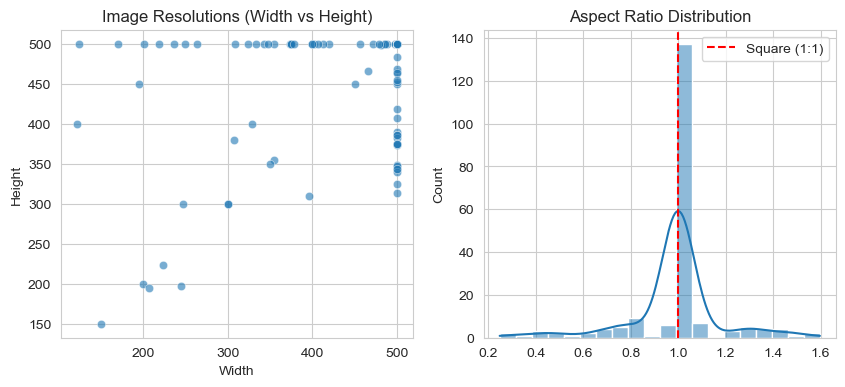

In [41]:
# Plot Resolution Distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=widths, y=heights, alpha=0.6)
plt.title('Image Resolutions (Width vs Height)')
plt.xlabel('Width')
plt.ylabel('Height')

plt.subplot(1, 2, 2)
sns.histplot(aspect_ratios, bins=20, kde=True)
plt.title('Aspect Ratio Distribution')
plt.axvline(1.0, color='r', linestyle='--', label='Square (1:1)')
plt.legend()
plt.show()

In [42]:
# Detection of "Weird" Shapes
# 1.0 is square. > 1.5 is wide banner. < 0.6 is tall skyscraper.
weird_shapes = sum([1 for r in aspect_ratios if r > 1.5 or r < 0.6])
print(f"Irregular shapes detected (Banners/Skyscrapers): {weird_shapes}")

Irregular shapes detected (Banners/Skyscrapers): 11


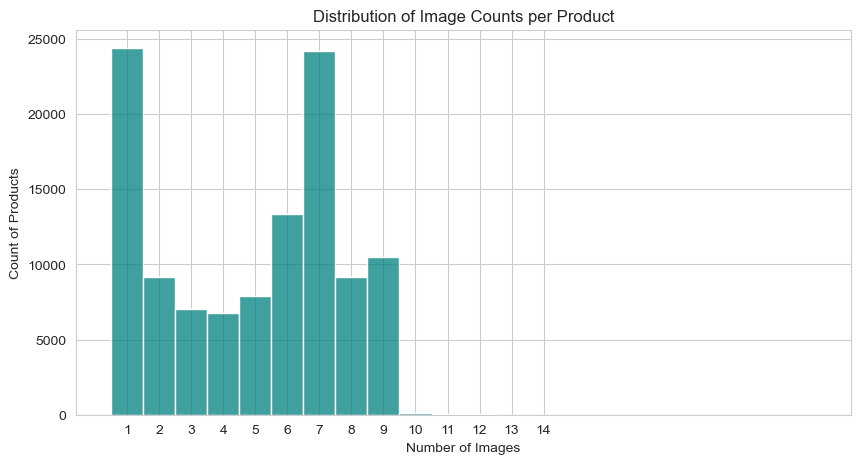

In [43]:
# Distribution of Image Counts (Single Shot vs Multi-Angle)
plt.figure(figsize=(10, 5))
# Filter 0 counts for better log scale visualization
counts = metadata_df[metadata_df['image_count'] > 0]['image_count']
sns.histplot(counts, discrete=True, color='teal')
plt.title('Distribution of Image Counts per Product')
plt.xlabel('Number of Images')
plt.ylabel('Count of Products')
plt.xticks(range(1, 15)) # Usually maxes out around 10-15
plt.show()

### 5.3 Content Diversity & Outlier Detection

In [44]:
# 1. Load CLIP Model
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

# 2. Generate Embeddings
# We process the downloaded images from the previous step
imgs_pil = [item['image'] for item in downloaded_images]

# Batch process images
inputs = processor(images=imgs_pil, return_tensors="pt", padding=True)

with torch.no_grad():
    image_features = model.get_image_features(**inputs)

# Normalize embeddings for cosine similarity
image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
embeddings = image_features.cpu().numpy()

print(f"Generated Embeddings Shape: {embeddings.shape}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Generated Embeddings Shape: (199, 512)


### 5.4 Visualizing Image Clusters (PCA)

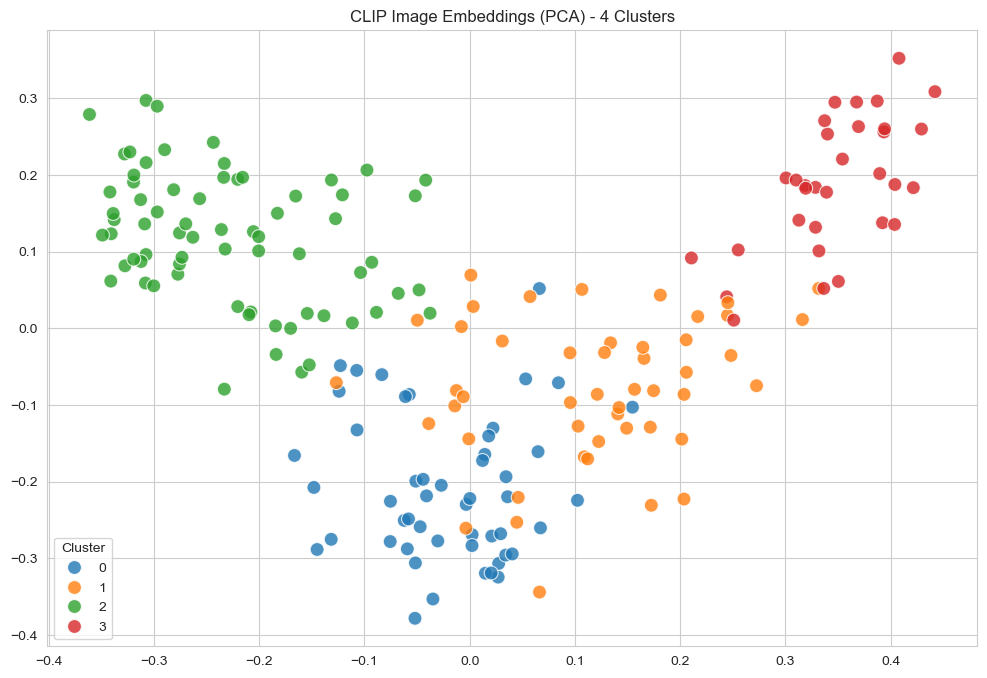

In [45]:
# 1. Reduce Dimensions (PCA)
pca = PCA(n_components=2)
coords = pca.fit_transform(embeddings)

# 2. Clustering (K-Means)
# We assume 4 broad clusters for Beauty: Bottles, Boxes, Tools, Faces/Usage
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)

# 3. Visualization
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=labels, palette='tab10', s=100, alpha=0.8)
plt.title(f'CLIP Image Embeddings (PCA) - {k} Clusters')
plt.legend(title='Cluster')

plt.show()